In [1]:
pip install smolagents yfinance prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.7/81.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.1

In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from smolagents import CodeAgent, ToolCallingAgent
from transformers import pipeline
from prophet import Prophet

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [3]:
# Any asset

# Define the agent for fetching asset data
class AssetDataAgent(CodeAgent):
    def __init__(self, asset_ticker):
        self.asset_ticker = asset_ticker

    def run(self):
        # Fetch asset data using yfinance
        asset_data = yf.Ticker(self.asset_ticker)
        return asset_data

# Define the agent for generating financial report
class FinancialReportAgent(CodeAgent):
    def __init__(self, asset_data):
        self.asset_data = asset_data

    def run(self):
        # Generate financial report
        info = self.asset_data.info
        report = f"# Financial Report for {info['shortName']}\n\n"
        report += f"**Sector:** {info.get('sector', 'N/A')}\n\n"
        report += f"**Industry:** {info.get('industry', 'N/A')}\n\n"
        report += f"**Market Cap:** {info.get('marketCap', 'N/A')}\n\n"
        report += f"**52 Week High:** {info.get('fiftyTwoWeekHigh', 'N/A')}\n\n"
        report += f"**52 Week Low:** {info.get('fiftyTwoWeekLow', 'N/A')}\n\n"
        return report

# Define the agent for generating trend charts
class TrendChartAgent(CodeAgent):
    def __init__(self, asset_data, start_date, end_date, purchase_price, forecast):
        self.asset_data = asset_data
        self.start_date = start_date
        self.end_date = end_date
        self.purchase_price = purchase_price
        self.forecast = forecast

    def run(self):
        # Generate trend charts
        hist = self.asset_data.history(start=self.start_date, end=self.end_date)
        plt.figure(figsize=(10, 5))
        plt.plot(hist.index, hist['Close'], label='Close Price')
        plt.axhline(y=self.purchase_price, color='r', linestyle='--', label='Purchase Price')
        plt.plot(self.forecast['ds'], self.forecast['yhat'], label='Forecast', linestyle='--', color='g')
        plt.title('Asset Price Trend')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.savefig('trend_chart.png')
        return "!Trend Chart"

# Define the agent for generating financial overview
class FinancialOverviewAgent(CodeAgent):
    def __init__(self, asset_data):
        self.asset_data = asset_data

    def run(self):
        # Generate financial overview
        financials = self.asset_data.financials if hasattr(self.asset_data, 'financials') else pd.DataFrame()
        overview = f"# Financial Overview for {self.asset_data.info['shortName']}\n\n"
        overview += financials.to_markdown() if not financials.empty else "No financial data available."
        return overview

# Define the agent for generating narrative using LLM
class FinancialNarrativeAgent(CodeAgent):
    def __init__(self, financial_overview):
        self.financial_overview = financial_overview
        self.model = pipeline("text2text-generation", model="google/flan-t5-large")

    def run(self):
        # Generate narrative using LLM
        prompt = f"Generate a narrative describing the most relevant items of the financial overview:\n\n{self.financial_overview}"
        narrative = self.model(prompt, max_length=500)[0]['generated_text']
        return narrative

# Define the agent for providing investment status
class InvestmentStatusAgent(CodeAgent):
    def __init__(self, asset_data, purchase_price, purchase_date):
        self.asset_data = asset_data
        self.purchase_price = purchase_price
        self.purchase_date = purchase_date

    def run(self):
        # Fetch historical data from the purchase date to today
        hist = self.asset_data.history(start=self.purchase_date)

        # Get the closing price on the purchase date and today
        purchase_close_price = hist.loc[self.purchase_date]['Close']
        current_close_price = hist['Close'].iloc[-1]

        # Calculate investment status
        investment_status = current_close_price - self.purchase_price

        status_report = f"# Investment Status\n\n"
        status_report += f"**Purchase Date:** {self.purchase_date}\n\n"
        status_report += f"**Purchase Price:** {self.purchase_price}\n\n"
        status_report += f"**Current Price:** {current_close_price}\n\n"

        if investment_status > 0:
            status_report += f"**Status:** Profit of {investment_status} per unit\n\n"
        else:
            status_report += f"**Status:** Loss of {abs(investment_status)} per unit\n\n"

        return status_report

# Define the agent for forecasting future prices using Prophet
class ForecastingAgent(CodeAgent):
    def __init__(self, asset_data, start_date, end_date):
        self.asset_data = asset_data
        self.start_date = start_date
        self.end_date = end_date

    def run(self):
        # Generate forecast forward of 10% of historical data length using Prophet
        hist = self.asset_data.history(start=self.start_date, end=self.end_date)

        # Prepare data for Prophet model
        df = hist.reset_index()[['Date', 'Close']]
        df.columns = ['ds', 'y']

        # Remove timezone information from 'ds' column
        df['ds'] = df['ds'].dt.tz_localize(None)

        # Calculate forecast period (10% of historical data length)
        forecast_period = int(len(df) * 0.1)

        # Fit model and generate forecast
        model = Prophet()
        model.fit(df)

        future_dates = model.make_future_dataframe(periods=forecast_period)
        forecast = model.predict(future_dates)

        return forecast[['ds', 'yhat']]

# Define the multi-agent system
class FinancialReportMultiAgent(ToolCallingAgent):
    def __init__(self, asset_ticker, start_date, end_date, purchase_price, purchase_date):
        self.asset_ticker = asset_ticker
        self.start_date = start_date
        self.end_date = end_date
        self.purchase_price = purchase_price
        self.purchase_date = purchase_date

    def run(self):
        # Create agents
        asset_data_agent = AssetDataAgent(self.asset_ticker)
        asset_data = asset_data_agent.run()

        financial_report_agent = FinancialReportAgent(asset_data)
        financial_report = financial_report_agent.run()

        forecasting_agent = ForecastingAgent(asset_data, self.start_date, self.end_date)
        forecast = forecasting_agent.run()

        trend_chart_agent = TrendChartAgent(asset_data, self.start_date, self.end_date, self.purchase_price, forecast)
        trend_chart = trend_chart_agent.run()

        financial_overview_agent = FinancialOverviewAgent(asset_data)
        financial_overview = financial_overview_agent.run()

        financial_narrative_agent = FinancialNarrativeAgent(financial_overview)
        financial_narrative = financial_narrative_agent.run()

        investment_status_agent = InvestmentStatusAgent(asset_data, self.purchase_price, self.purchase_date)
        investment_status = investment_status_agent.run()

        # Combine results
        report = financial_report + "\n\n" + trend_chart + "\n\n" + financial_overview + "\n\n" + financial_narrative + "\n\n" + investment_status
        return report

In [4]:
# Receive human input for asset ticker, date range, and investment details
asset_ticker = input("Enter the asset ticker: ")
start_date = input("Enter the start date (YYYY-MM-DD): ")
end_date = input("Enter the end date (YYYY-MM-DD): ")
purchase_price = float(input("Enter the purchase price: "))
purchase_date = input("Enter the purchase date (YYYY-MM-DD): ")

Enter the asset ticker: BTC-USD
Enter the start date (YYYY-MM-DD): 2022-01-01
Enter the end date (YYYY-MM-DD): 2025-01-07
Enter the purchase price: 62800
Enter the purchase date (YYYY-MM-DD): 2024-05-18


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf1sn7hip/d4d6pfie.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf1sn7hip/54ror3mk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17609', 'data', 'file=/tmp/tmpf1sn7hip/d4d6pfie.json', 'init=/tmp/tmpf1sn7hip/54ror3mk.json', 'output', 'file=/tmp/tmpf1sn7hip/prophet_modelk8j25qth/prophet_model-20250110005132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:51:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab se

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu


# Financial Report for Bitcoin USD

**Sector:** N/A

**Industry:** N/A

**Market Cap:** 1833765306368

**52 Week High:** 108268.445

**52 Week Low:** 38521.895



!Trend Chart

# Financial Overview for Bitcoin USD

No financial data available.

The Bitcoin USD is a crypto currency that is used to buy and sell goods and services. It is a digital currency that is based on the Bitcoin cryptographic hashing algorithm.

# Investment Status

**Purchase Date:** 2024-05-18

**Purchase Price:** 62800.0

**Current Price:** 92669.4453125

**Status:** Profit of 29869.4453125 per unit




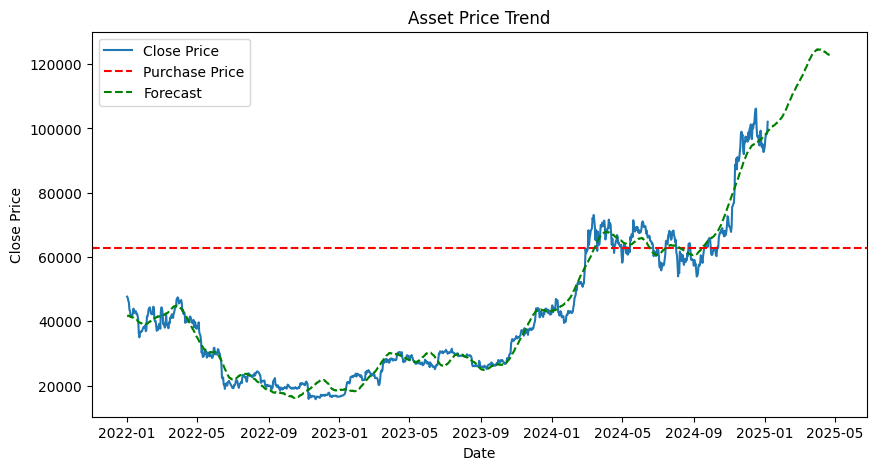

In [5]:
# Create and run the multi-agent system
multi_agent_system = FinancialReportMultiAgent(asset_ticker, start_date, end_date, purchase_price, purchase_date)
report = multi_agent_system.run()

# Output the report in markdown format
print(report)

# Financial Report for Bitcoin USD

**Sector:** N/A

**Industry:** N/A

**Market Cap:** 1833765306368

**52 Week High:** 108268.445

**52 Week Low:** 38521.895



!Trend Chart

# Financial Overview for Bitcoin USD

No financial data available.

The Bitcoin USD is a crypto currency that is used to buy and sell goods and services. It is a digital currency that is based on the Bitcoin cryptographic hashing algorithm.

# Investment Status

**Purchase Date:** 2024-05-18

**Purchase Price:** 62800.0

**Current Price:** 92669.4453125

**Status:** Profit of 29869.4453125 per unit


